# 01 — Exploratory Data Analysis: South Carolina Energy Grid
**Team:** QuantumPulse | **Track:** Hardware · Rigetti Computing

This notebook covers complete EDA for both Problem A (21 nodes, 28 edges) and Problem B (180 nodes, 226 edges), including:
- Dataset loading & validation
- Graph topology analysis
- Edge weight statistics
- Community detection
- Spectral analysis
- Hardware-ready subgraph extraction
- Exact MaxCut (Problem A brute force)
- Resource estimation for standard QAOA
- Classical baseline benchmarking (one_exchange)
- Problem B scalability analysis

## 0. Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import networkx as nx
from itertools import product
from networkx.algorithms.community import greedy_modularity_communities
from networkx.linalg.spectrum import laplacian_spectrum

plt.style.use('seaborn-v0_8-darkgrid')
SEED = 42
print('All imports OK')

All imports OK


---
## 1. Problem A — Dataset Loading & Validation

In [2]:
# Load Problem A
dfA = pd.read_parquet('problemA.parquet')

print('=== Problem A: Basic Info ===')
print(f'Shape:         {dfA.shape}  (rows=edges, cols=node_1, node_2, weight)')
print(f'Null values:   {dfA.isnull().sum().sum()}  (expected: 0)')
print(f'Dtypes:\n{dfA.dtypes}\n')
dfA.head(10)

=== Problem A: Basic Info ===
Shape:         (28, 3)  (rows=edges, cols=node_1, node_2, weight)
Null values:   0  (expected: 0)
Dtypes:
node_1     uint64
node_2     uint64
weight    float64
dtype: object



,node_1,node_2,weight
0,3,13,67.340839
1,3,16,72.559721
2,2,5,382.718543
3,5,14,41.827958
4,5,20,79.566259
5,1,5,141.631447
6,7,8,172.407155
7,8,17,144.547863
8,10,19,40.841596
9,10,18,114.334224


In [3]:
dfA.describe()

,node_1,node_2,weight
count,28.000000,28.000000,28.000000
mean,5.464286,13.428571,150.559481
std,4.384165,4.709554,95.015539
min,0.000000,4.000000,40.841596
25%,1.750000,10.500000,71.977290
50%,4.500000,14.000000,136.501484
75%,8.250000,17.000000,186.838566
max,15.000000,20.000000,382.718543


## 2. Problem A — Graph Construction & Topology

In [4]:
# Build graph
GA = nx.Graph()
for _, row in dfA.iterrows():
    GA.add_edge(int(row['node_1']), int(row['node_2']), weight=row['weight'])

print('=== Problem A: Graph Topology ===')
print(f'Nodes:              {GA.number_of_nodes()}')
print(f'Edges:              {GA.number_of_edges()}')
print(f'Density:            {nx.density(GA):.4f}')
print(f'Is connected:       {nx.is_connected(GA)}')
print(f'Num components:     {nx.number_connected_components(GA)}')
print(f'Avg clustering:     {nx.average_clustering(GA):.4f}')
print(f'Avg shortest path:  {nx.average_shortest_path_length(GA):.4f}')
print(f'Diameter:           {nx.diameter(GA)}')

=== Problem A: Graph Topology ===
Nodes:              21
Edges:              28
Density:            0.1333
Is connected:       True
Num components:     1
Avg clustering:     0.2714
Avg shortest path:  3.7381
Diameter:           8


=== Node Degree Statistics (unweighted) ===
Min degree:    2
Max degree:    5
Mean degree:   2.67
Degree counts: [2, 3, 4, 5]


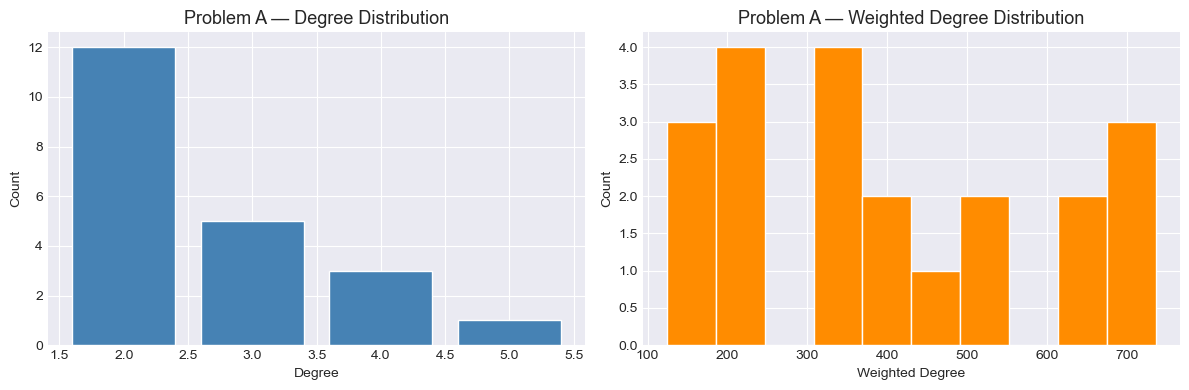

In [5]:
# Degree distribution
degrees_A = dict(GA.degree())
deg_vals = list(degrees_A.values())

print('=== Node Degree Statistics (unweighted) ===')
print(f'Min degree:    {min(deg_vals)}')
print(f'Max degree:    {max(deg_vals)}')
print(f'Mean degree:   {np.mean(deg_vals):.2f}')
print(f'Degree counts: {sorted(set(deg_vals))}')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Degree histogram
axes[0].bar(*np.unique(deg_vals, return_counts=True), color='steelblue', edgecolor='white')
axes[0].set_title('Problem A — Degree Distribution', fontsize=13)
axes[0].set_xlabel('Degree'); axes[0].set_ylabel('Count')

# Weighted degree histogram
w_degs = [GA.degree(n, weight='weight') for n in GA.nodes()]
axes[1].hist(w_degs, bins=10, color='darkorange', edgecolor='white')
axes[1].set_title('Problem A — Weighted Degree Distribution', fontsize=13)
axes[1].set_xlabel('Weighted Degree'); axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

## 3. Problem A — Edge Weight Analysis

=== Problem A: Edge Weight Statistics ===
Count:  28
Mean:   150.5595
Std:    93.3034
Min:    40.8416
Median: 136.5015
Max:    382.7185
CV:     0.6197  (coeff. of variation — >0.5 means high variance)


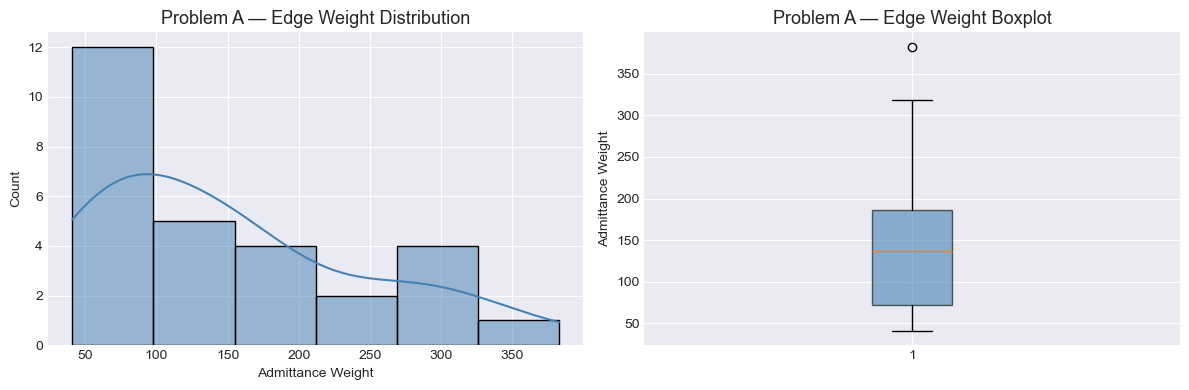

In [6]:
weights_A = [d['weight'] for _, _, d in GA.edges(data=True)]

print('=== Problem A: Edge Weight Statistics ===')
print(f'Count:  {len(weights_A)}')
print(f'Mean:   {np.mean(weights_A):.4f}')
print(f'Std:    {np.std(weights_A):.4f}')
print(f'Min:    {np.min(weights_A):.4f}')
print(f'Median: {np.median(weights_A):.4f}')
print(f'Max:    {np.max(weights_A):.4f}')
print(f'CV:     {np.std(weights_A)/np.mean(weights_A):.4f}  (coeff. of variation — >0.5 means high variance)')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(weights_A, kde=True, ax=axes[0], color='steelblue')
axes[0].set_title('Problem A — Edge Weight Distribution', fontsize=13)
axes[0].set_xlabel('Admittance Weight')

axes[1].boxplot(weights_A, vert=True, patch_artist=True,
                boxprops=dict(facecolor='steelblue', alpha=0.6))
axes[1].set_title('Problem A — Edge Weight Boxplot', fontsize=13)
axes[1].set_ylabel('Admittance Weight')

plt.tight_layout()
plt.show()

## 4. Problem A — Community Detection (Modularity-Based)

Number of communities detected: 4
  Community 1 (8 nodes): [1, 2, 5, 7, 8, 15, 17, 20]
  Community 2 (5 nodes): [6, 10, 14, 18, 19]
  Community 3 (4 nodes): [3, 11, 13, 16]
  Community 4 (4 nodes): [0, 4, 9, 12]


C:\Users\rein7\AppData\Local\Temp\ipykernel_22344\4147688744.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', num_communities)
C:\Users\rein7\AppData\Local\Temp\ipykernel_22344\4147688744.py:39: UserWarning: Glyph 8733 (\N{PROPORTIONAL TO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\rein7\anaconda3\envs\hackathon\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8733 (\N{PROPORTIONAL TO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


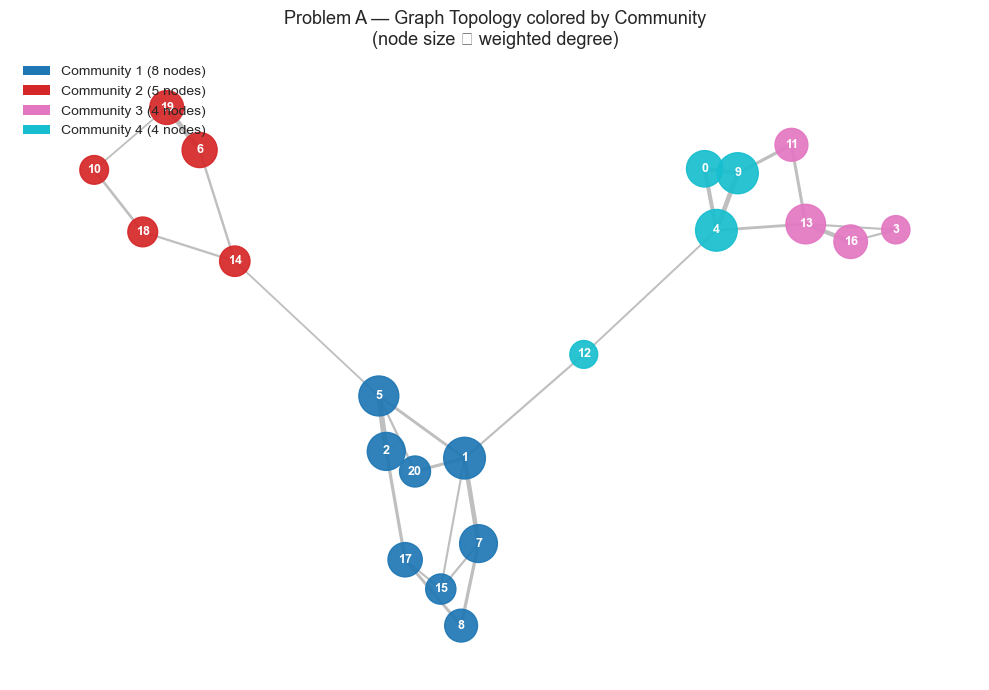

In [8]:
communities_A = list(greedy_modularity_communities(GA, weight='weight'))

print(f'Number of communities detected: {len(communities_A)}')
for idx, comm in enumerate(communities_A):
    print(f'  Community {idx+1} ({len(comm)} nodes): {sorted([int(n) for n in comm])}')

# Build color map
node_community = {}
for idx, comm in enumerate(communities_A):
    for node in comm:
        node_community[node] = idx

import matplotlib.cm as cm
import numpy as np

num_communities = len(communities_A)
cmap = cm.get_cmap('tab10', num_communities)
palette = [cmap(i) for i in range(num_communities)]
node_colors = [palette[node_community[n]] for n in GA.nodes()]

pos = nx.spring_layout(GA, seed=SEED)
w_degs_dict = dict(GA.degree(weight='weight'))
node_sizes = [300 + 600 * (w_degs_dict[n] / max(w_degs_dict.values())) for n in GA.nodes()]

plt.figure(figsize=(10, 7))
nx.draw_networkx_nodes(GA, pos, node_color=node_colors, node_size=node_sizes, alpha=0.92)
edge_weights = [GA[u][v]['weight'] for u, v in GA.edges()]
max_w = max(edge_weights)
nx.draw_networkx_edges(GA, pos, width=[1 + 3 * (w / max_w) for w in edge_weights],
                       alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(GA, pos, font_size=9, font_color='white', font_weight='bold')

from matplotlib.patches import Patch
legend = [Patch(facecolor=palette[i], label=f'Community {i+1} ({len(communities_A[i])} nodes)')
          for i in range(len(communities_A))]
plt.legend(handles=legend, loc='upper left', fontsize=10)
plt.title('Problem A — Graph Topology colored by Community\n(node size ∝ weighted degree)', fontsize=13)
plt.axis('off')
plt.tight_layout()
plt.show()

## 5. Problem A — Spectral Analysis (Weighted Laplacian)

=== Weighted Laplacian Eigenvalues (Problem A) ===
λ₀ (should be ≈0, connected): -1.30e-15
λ₁ (Fiedler / algebraic connectivity): 4.8680
λ₂:  12.9923
λ_max: 1086.6345

Interpretation:
  Fiedler value 4.8680 > 0 → graph is connected ✓
  Spectral gap (λ₁) = 4.8680 — moderate community separation
  High λ_max = 1086.6345 — some high-admittance backbone edges present


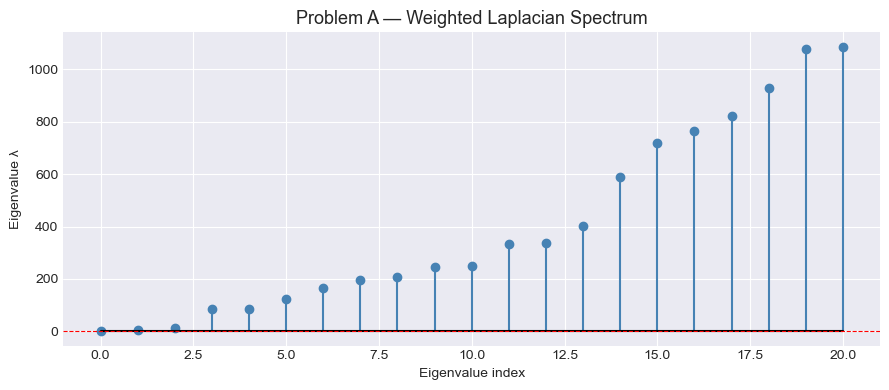

In [9]:
# Weighted Laplacian spectrum
lap_spec_A = sorted(laplacian_spectrum(GA, weight='weight'))

print('=== Weighted Laplacian Eigenvalues (Problem A) ===')
print(f'λ₀ (should be ≈0, connected): {lap_spec_A[0]:.2e}')
print(f'λ₁ (Fiedler / algebraic connectivity): {lap_spec_A[1]:.4f}')
print(f'λ₂:  {lap_spec_A[2]:.4f}')
print(f'λ_max: {lap_spec_A[-1]:.4f}')
print(f'\nInterpretation:')
print(f'  Fiedler value {lap_spec_A[1]:.4f} > 0 → graph is connected ✓')
print(f'  Spectral gap (λ₁) = {lap_spec_A[1]:.4f} — moderate community separation')
print(f'  High λ_max = {lap_spec_A[-1]:.4f} — some high-admittance backbone edges present')

plt.figure(figsize=(9, 4))
plt.stem(range(len(lap_spec_A)), lap_spec_A, basefmt='k-', linefmt='steelblue',
         markerfmt='o')
plt.title('Problem A — Weighted Laplacian Spectrum', fontsize=13)
plt.xlabel('Eigenvalue index')
plt.ylabel('Eigenvalue λ')
plt.axhline(0, color='red', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

## 6. Problem A — Edge Centrality & Critical Backbone Identification

=== Top-10 Edges by Betweenness Centrality (backbone/bridge candidates) ===
Edge          Betweenness      Weight    
------------------------------------------
( 1, 12)    0.495238         70.23
( 4, 12)    0.466667         54.23
( 5, 14)    0.380952         41.83
( 5,  1)    0.371429         141.63
( 1, 15)    0.347619         69.37
(13,  4)    0.300000         131.37
(14, 18)    0.252381         81.34
(17, 15)    0.219048         68.47
( 3, 13)    0.180952         67.34
(10, 18)    0.176190         114.33


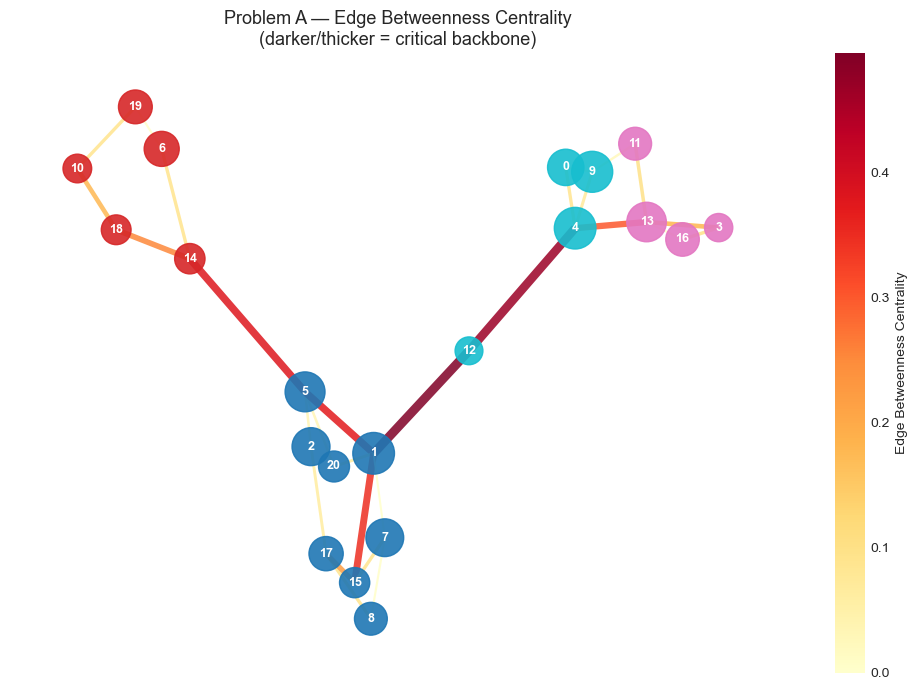

In [10]:
# Edge betweenness centrality — identifies backbone/bridge edges
ebc = nx.edge_betweenness_centrality(GA, weight='weight', normalized=True)
ebc_vals = sorted(ebc.items(), key=lambda x: x[1], reverse=True)

print('=== Top-10 Edges by Betweenness Centrality (backbone/bridge candidates) ===')
print(f'{"Edge":12s}  {"Betweenness":15s}  {"Weight":10s}')
print('-' * 42)
for (u, v), bc in ebc_vals[:10]:
    w = GA[u][v]['weight']
    print(f'({int(u):2d}, {int(v):2d})    {bc:.6f}         {w:.2f}')

# Visualize
pos = nx.spring_layout(GA, seed=SEED)
edge_bc_vals = [ebc.get((u, v), ebc.get((v, u), 0)) for u, v in GA.edges()]
max_bc = max(edge_bc_vals)

plt.figure(figsize=(10, 7))
nx.draw_networkx_nodes(GA, pos, node_color=node_colors, node_size=node_sizes, alpha=0.9)
edges_drawn = nx.draw_networkx_edges(
    GA, pos,
    edge_color=edge_bc_vals,
    edge_cmap=plt.cm.YlOrRd,
    width=[1.5 + 5 * (v / max_bc) for v in edge_bc_vals],
    alpha=0.85
)
nx.draw_networkx_labels(GA, pos, font_size=9, font_color='white', font_weight='bold')
sm = plt.cm.ScalarMappable(cmap=plt.cm.YlOrRd,
                            norm=plt.Normalize(vmin=0, vmax=max_bc))
plt.colorbar(sm, ax=plt.gca(), label='Edge Betweenness Centrality')
plt.title('Problem A — Edge Betweenness Centrality\n(darker/thicker = critical backbone)', fontsize=13)
plt.axis('off')
plt.tight_layout()
plt.show()

## 7. Problem A — Exact MaxCut (Brute Force, Ground Truth)

In [11]:
def exact_maxcut(graph):
    """Brute-force exact MaxCut. Feasible only for n <= 22."""
    nodes = list(graph.nodes())
    n = len(nodes)
    best_val = -np.inf
    best_partition = None
    
    for bitmask in range(1 << n):
        cut_value = 0
        assignment = [(bitmask >> i) & 1 for i in range(n)]
        for u, v, data in graph.edges(data=True):
            if assignment[nodes.index(u)] != assignment[nodes.index(v)]:
                cut_value += data['weight']
        if cut_value > best_val:
            best_val = cut_value
            best_partition = assignment
    
    return best_val, {nodes[i]: best_partition[i] for i in range(n)}

n_A = GA.number_of_nodes()
print(f'Problem A has {n_A} nodes → 2^{n_A} = {2**n_A:,} partitions to enumerate.')
print('Running brute force...')
exact_val_A, best_partition_A = exact_maxcut(GA)
print(f'\n✅ EXACT MPES (Problem A): {exact_val_A:.6f}')

# Report partition
side0 = sorted([int(n) for n, s in best_partition_A.items() if s == 0])
side1 = sorted([int(n) for n, s in best_partition_A.items() if s == 1])
print(f'Optimal partition:')
print(f'  Side 0 ({len(side0)} nodes): {side0}')
print(f'  Side 1 ({len(side1)} nodes): {side1}')

Problem A has 21 nodes → 2^21 = 2,097,152 partitions to enumerate.
Running brute force...

✅ EXACT MPES (Problem A): 3728.413221
Optimal partition:
  Side 0 (10 nodes): [1, 2, 4, 8, 10, 11, 14, 15, 16, 19]
  Side 1 (11 nodes): [0, 3, 5, 6, 7, 9, 12, 13, 17, 18, 20]


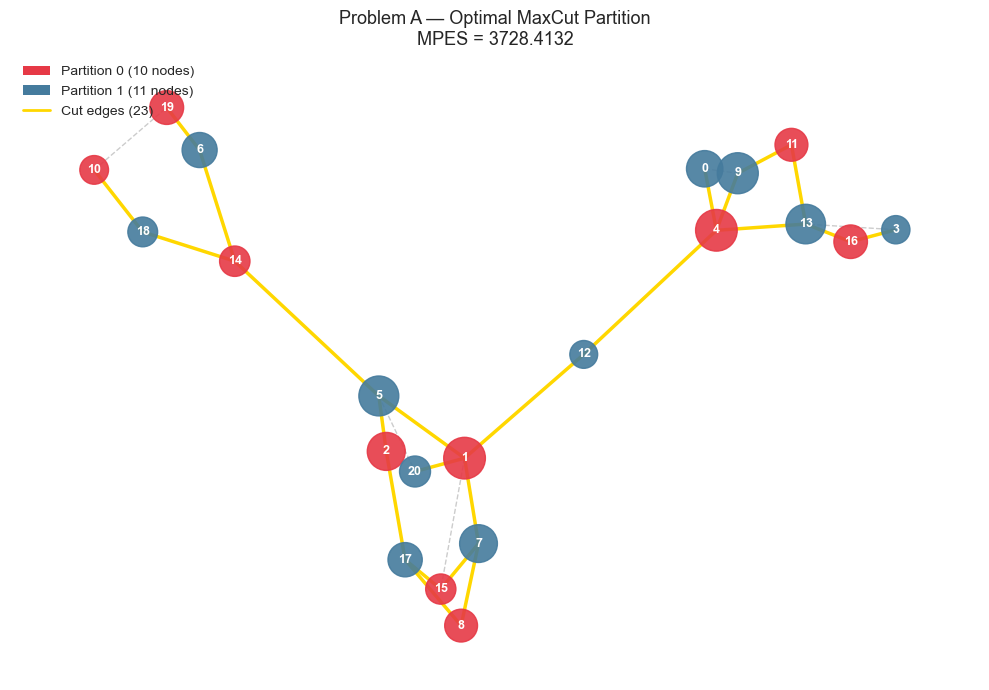

In [12]:
# Visualize optimal partition
opt_colors = ['#E63946' if best_partition_A[n] == 0 else '#457B9D' for n in GA.nodes()]

plt.figure(figsize=(10, 7))
nx.draw_networkx_nodes(GA, pos, node_color=opt_colors, node_size=node_sizes, alpha=0.9)

cut_edges = [(u, v) for u, v in GA.edges() if best_partition_A[u] != best_partition_A[v]]
non_cut = [(u, v) for u, v in GA.edges() if best_partition_A[u] == best_partition_A[v]]

nx.draw_networkx_edges(GA, pos, edgelist=cut_edges, edge_color='gold',
                       width=2.5, style='solid', label='Cut edges')
nx.draw_networkx_edges(GA, pos, edgelist=non_cut, edge_color='gray',
                       width=1, style='dashed', alpha=0.4)
nx.draw_networkx_labels(GA, pos, font_size=9, font_color='white', font_weight='bold')

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend = [
    Patch(facecolor='#E63946', label=f'Partition 0 ({len(side0)} nodes)'),
    Patch(facecolor='#457B9D', label=f'Partition 1 ({len(side1)} nodes)'),
    Line2D([0], [0], color='gold', linewidth=2, label=f'Cut edges ({len(cut_edges)})')
]
plt.legend(handles=legend, loc='upper left', fontsize=10)
plt.title(f'Problem A — Optimal MaxCut Partition\nMPES = {exact_val_A:.4f}', fontsize=13)
plt.axis('off')
plt.tight_layout()
plt.show()

## 8. Problem A — Classical Baseline: one_exchange greedy

In [13]:
from networkx.algorithms.approximation import one_exchange

# one_exchange returns (cut_size, partition_set)
greedy_result_A = one_exchange(GA, weight='weight', seed=SEED)
greedy_val_A = greedy_result_A[0]

approx_ratio_A = greedy_val_A / exact_val_A

print('=== Classical Baseline: one_exchange (Problem A) ===')
print(f'Greedy cut value:    {greedy_val_A:.6f}')
print(f'Exact MPES:          {exact_val_A:.6f}')
print(f'Approximation ratio: {approx_ratio_A:.4f}  ({approx_ratio_A*100:.2f}% of optimal)')
print(f'\nThis is our quantum target: beat {approx_ratio_A:.4f} approximation ratio.')

=== Classical Baseline: one_exchange (Problem A) ===
Greedy cut value:    3632.356625
Exact MPES:          3728.413221
Approximation ratio: 0.9742  (97.42% of optimal)

This is our quantum target: beat 0.9742 approximation ratio.


## 9. Problem A — Hardware Subgraph Extraction (8-node, Rigetti Target)

In [14]:
# Strategy: BFS from highest weighted-degree node to get a connected 8-node subgraph
sorted_by_wdeg = sorted(GA.degree(weight='weight'), key=lambda x: x[1], reverse=True)
print('Top-5 nodes by weighted degree:')
for node, wd in sorted_by_wdeg[:5]:
    print(f'  Node {int(node):2d}: weighted degree = {wd:.2f}')

start_node = sorted_by_wdeg[0][0]
target_size = 8

visited = set([start_node])
frontier = [start_node]

while len(visited) < target_size and frontier:
    current = frontier.pop(0)
    for nb in GA.neighbors(current):
        if nb not in visited:
            visited.add(nb)
            frontier.append(nb)
        if len(visited) >= target_size:
            break

hwG = GA.subgraph(visited).copy()

print(f'\n=== Hardware-ready subgraph (BFS from node {int(start_node)}) ===')
print(f'Nodes:      {hwG.number_of_nodes()}')
print(f'Edges:      {hwG.number_of_edges()}')
print(f'Connected:  {nx.is_connected(hwG)}')
print(f'Density:    {nx.density(hwG):.4f}')
print(f'Node list:  {sorted([int(n) for n in hwG.nodes()])}')

Top-5 nodes by weighted degree:
  Node  1: weighted degree = 736.05
  Node  4: weighted degree = 734.50
  Node  9: weighted degree = 701.84
  Node  5: weighted degree = 645.74
  Node 13: weighted degree = 626.43

=== Hardware-ready subgraph (BFS from node 1) ===
Nodes:      8
Edges:      9
Connected:  True
Density:    0.3214
Node list:  [1, 2, 5, 7, 12, 14, 15, 20]


Hardware subgraph — Exact MaxCut: 1165.8433
Hardware subgraph — Greedy:       1165.8433  (approx ratio: 1.0000)

This is the benchmark your QAOA circuit must beat on Rigetti hardware.


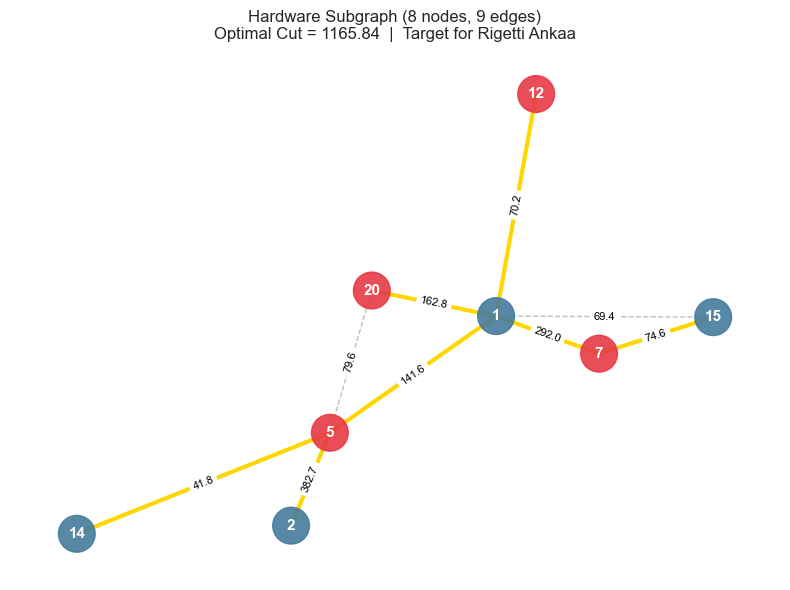

In [15]:
# Exact MaxCut on the hardware subgraph
exact_hw, best_hw_partition = exact_maxcut(hwG)
greedy_hw = one_exchange(hwG, weight='weight', seed=SEED)[0]

print(f'Hardware subgraph — Exact MaxCut: {exact_hw:.4f}')
print(f'Hardware subgraph — Greedy:       {greedy_hw:.4f}  (approx ratio: {greedy_hw/exact_hw:.4f})')
print(f'\nThis is the benchmark your QAOA circuit must beat on Rigetti hardware.')

# Visualize hardware subgraph
hw_colors = ['#E63946' if best_hw_partition[n] == 0 else '#457B9D' for n in hwG.nodes()]
pos_hw = nx.spring_layout(hwG, seed=SEED)
hw_cut_edges = [(u, v) for u, v in hwG.edges() if best_hw_partition[u] != best_hw_partition[v]]
hw_non_cut = [(u, v) for u, v in hwG.edges() if best_hw_partition[u] == best_hw_partition[v]]

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(hwG, pos_hw, node_color=hw_colors, node_size=700, alpha=0.9)
nx.draw_networkx_edges(hwG, pos_hw, edgelist=hw_cut_edges,
                       edge_color='gold', width=3, label='Cut edges')
nx.draw_networkx_edges(hwG, pos_hw, edgelist=hw_non_cut,
                       edge_color='gray', width=1, style='dashed', alpha=0.5)
nx.draw_networkx_labels(hwG, pos_hw, font_size=11, font_color='white', font_weight='bold')
edge_labels_hw = {(u, v): f'{hwG[u][v]["weight"]:.1f}' for u, v in hwG.edges()}
nx.draw_networkx_edge_labels(hwG, pos_hw, edge_labels=edge_labels_hw, font_size=8)
plt.title(f'Hardware Subgraph ({hwG.number_of_nodes()} nodes, {hwG.number_of_edges()} edges)\n'
          f'Optimal Cut = {exact_hw:.2f}  |  Target for Rigetti Ankaa', fontsize=12)
plt.axis('off')
plt.tight_layout()
plt.show()

## 10. Resource Estimation — Why Standard QAOA Fails

In [16]:
def qaoa_resource_estimate(n_nodes, n_edges, p_layers, avg_swap_overhead=3):
    """Estimate QAOA circuit resources for standard one-qubit-per-node encoding."""
    qubits = n_nodes
    # Cost layer: one RZZ per edge per layer
    two_qubit_gates_ideal = p_layers * n_edges
    # Swap overhead for non-adjacent qubits on a square grid
    two_qubit_gates_with_swap = two_qubit_gates_ideal * avg_swap_overhead
    # Mixer layer: one RX per qubit per layer
    single_qubit_gates = p_layers * n_nodes
    # Circuit depth (rough lower bound)
    circuit_depth = p_layers * (n_edges + n_nodes)  # very rough
    
    return {
        'qubits': qubits,
        '2q_gates_ideal': two_qubit_gates_ideal,
        '2q_gates_with_swap': two_qubit_gates_with_swap,
        '1q_gates': single_qubit_gates,
        'circuit_depth': circuit_depth
    }

print('=== QAOA Resource Estimation (one-node-per-qubit encoding) ===')
print()

configs = [
    ('Problem A (p=1)', 21, 28, 1),
    ('Problem A (p=5)', 21, 28, 5),
    ('Problem B (p=1)', 180, 226, 1),
    ('Problem B (p=5)', 180, 226, 5),
    ('Rigetti target (p=1)', 8, 9, 1),
]

print(f'{"Config":30s} {"Qubits":8s} {"2Q ideal":10s} {"2Q+SWAP":10s} {"1Q gates":10s} {"Feasible?"}')
print('-' * 85)
for label, n, e, p in configs:
    r = qaoa_resource_estimate(n, e, p)
    feasible = '✅ YES' if r['qubits'] <= 12 and r['2q_gates_with_swap'] <= 100 else '❌ NO'
    print(f'{label:30s} {r["qubits"]:8d} {r["2q_gates_ideal"]:10d} {r["2q_gates_with_swap"]:10d} {r["1q_gates"]:10d} {feasible}')

print()
print('Notes:')
print('  • Rigetti Ankaa-3 targets: ~10-qubit circuits, ≤100 two-qubit gates')
print('  • SWAP overhead ~3x assumed (non-adjacent qubits on square topology)')
print('  • Problem B with 180 qubits is completely infeasible on current NISQ hardware')
print('  • Classical simulation of n=180 qubits requires 2^180 ~ 10^54 complex amplitudes → impossible')

=== QAOA Resource Estimation (one-node-per-qubit encoding) ===

Config                         Qubits   2Q ideal   2Q+SWAP    1Q gates   Feasible?
-------------------------------------------------------------------------------------
Problem A (p=1)                      21         28         84         21 ❌ NO
Problem A (p=5)                      21        140        420        105 ❌ NO
Problem B (p=1)                     180        226        678        180 ❌ NO
Problem B (p=5)                     180       1130       3390        900 ❌ NO
Rigetti target (p=1)                  8          9         27          8 ✅ YES

Notes:
  • Rigetti Ankaa-3 targets: ~10-qubit circuits, ≤100 two-qubit gates
  • SWAP overhead ~3x assumed (non-adjacent qubits on square topology)
  • Problem B with 180 qubits is completely infeasible on current NISQ hardware
  • Classical simulation of n=180 qubits requires 2^180 ~ 10^54 complex amplitudes → impossible


## 11. Problem B — Full EDA

In [17]:
dfB = pd.read_parquet('problemB.parquet')

print('=== Problem B: Basic Info ===')
print(f'Shape:       {dfB.shape}')
print(f'Null values: {dfB.isnull().sum().sum()}')
dfB.head(8)

=== Problem B: Basic Info ===
Shape:       (226, 3)
Null values: 0


,node_1,node_2,weight
0,0,95,27.793274
1,0,150,52.473872
2,1,117,36.671308
3,1,120,73.897339
4,2,73,26.141222
5,2,101,46.910817
6,2,144,66.197753
7,3,30,21.582226


In [18]:
GB = nx.Graph()
for _, row in dfB.iterrows():
    GB.add_edge(int(row['node_1']), int(row['node_2']), weight=row['weight'])

print('=== Problem B: Graph Topology ===')
print(f'Nodes:             {GB.number_of_nodes()}')
print(f'Edges:             {GB.number_of_edges()}')
print(f'Density:           {nx.density(GB):.6f}  (very sparse — typical for power grids)')
print(f'Is connected:      {nx.is_connected(GB)}')
print(f'Num components:    {nx.number_connected_components(GB)}')
print(f'Avg clustering:    {nx.average_clustering(GB):.6f}')

degs_B = [d for _, d in GB.degree()]
print(f'Min degree:        {min(degs_B)}')
print(f'Max degree:        {max(degs_B)}')
print(f'Mean degree:       {np.mean(degs_B):.3f}')

=== Problem B: Graph Topology ===
Nodes:             180
Edges:             226
Density:           0.014029  (very sparse — typical for power grids)
Is connected:      True
Num components:    1
Avg clustering:    0.087751
Min degree:        2
Max degree:        7
Mean degree:       2.511


=== Problem B: Edge Weight Statistics ===
Mean:   33.0341
Std:    16.2900
Min:    7.8255
Median: 30.0937
Max:    119.8960
CV:     0.4931


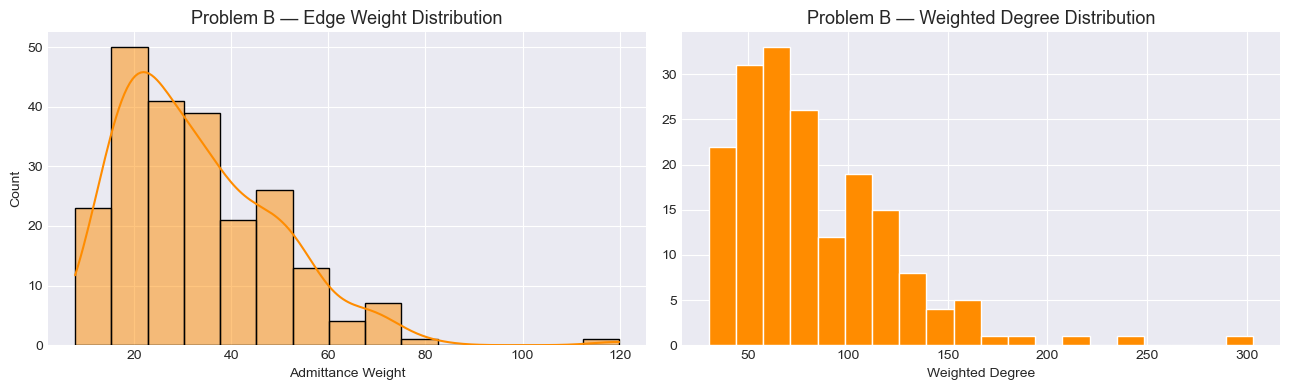

In [19]:
weights_B = [d['weight'] for _, _, d in GB.edges(data=True)]

print('=== Problem B: Edge Weight Statistics ===')
print(f'Mean:   {np.mean(weights_B):.4f}')
print(f'Std:    {np.std(weights_B):.4f}')
print(f'Min:    {np.min(weights_B):.4f}')
print(f'Median: {np.median(weights_B):.4f}')
print(f'Max:    {np.max(weights_B):.4f}')
print(f'CV:     {np.std(weights_B)/np.mean(weights_B):.4f}')

fig, axes = plt.subplots(1, 2, figsize=(13, 4))

sns.histplot(weights_B, kde=True, ax=axes[0], color='darkorange')
axes[0].set_title('Problem B — Edge Weight Distribution', fontsize=13)
axes[0].set_xlabel('Admittance Weight')

degs_B_vals = [GB.degree(n, weight='weight') for n in GB.nodes()]
axes[1].hist(degs_B_vals, bins=20, color='darkorange', edgecolor='white')
axes[1].set_title('Problem B — Weighted Degree Distribution', fontsize=13)
axes[1].set_xlabel('Weighted Degree')

plt.tight_layout()
plt.show()

=== Problem B: Community Structure ===
Number of communities: 15
Community sizes: [21, 21, 19, 16, 14, 14, 13, 10, 9, 8, 8, 7, 7, 7, 6]
Largest:         21 nodes
Smallest:        6 nodes
Mean size:       12.0 nodes
Std size:        5.1 nodes


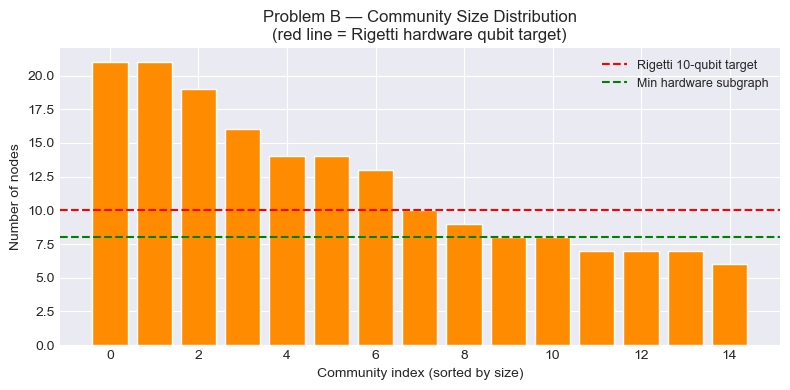


Implication: Most communities exceed the 10-qubit hardware target.
Further sub-decomposition required for hardware execution.


In [20]:
# Community detection on Problem B
communities_B = list(greedy_modularity_communities(GB, weight='weight'))

print(f'=== Problem B: Community Structure ===')
print(f'Number of communities: {len(communities_B)}')
sizes_B = sorted([len(c) for c in communities_B], reverse=True)
print(f'Community sizes: {sizes_B}')
print(f'Largest:         {sizes_B[0]} nodes')
print(f'Smallest:        {sizes_B[-1]} nodes')
print(f'Mean size:       {np.mean(sizes_B):.1f} nodes')
print(f'Std size:        {np.std(sizes_B):.1f} nodes')

plt.figure(figsize=(8, 4))
plt.bar(range(len(sizes_B)), sizes_B, color='darkorange', edgecolor='white')
plt.axhline(10, color='red', linestyle='--', label='Rigetti 10-qubit target')
plt.axhline(8, color='green', linestyle='--', label='Min hardware subgraph')
plt.title('Problem B — Community Size Distribution\n(red line = Rigetti hardware qubit target)', fontsize=12)
plt.xlabel('Community index (sorted by size)')
plt.ylabel('Number of nodes')
plt.legend(fontsize=9)
plt.tight_layout()
plt.show()

print(f'\nImplication: Most communities exceed the 10-qubit hardware target.')
print(f'Further sub-decomposition required for hardware execution.')

In [21]:
# Weighted Laplacian Fiedler value (algebraic connectivity) for Problem B
fiedler_B = nx.algebraic_connectivity(GB, weight='weight', method='tracemin_pcg')
print(f'=== Problem B: Algebraic Connectivity (Fiedler Value) ===')
print(f'λ₁ = {fiedler_B:.6f}')
print(f'Interpretation: Small Fiedler value ({fiedler_B:.4f}) means the graph')
print(f'has clear community structure and is relatively easy to decompose — good for our strategy.')

=== Problem B: Algebraic Connectivity (Fiedler Value) ===
λ₁ = 0.105057
Interpretation: Small Fiedler value (0.1051) means the graph
has clear community structure and is relatively easy to decompose — good for our strategy.


In [22]:
# Classical baseline for Problem B
greedy_B = one_exchange(GB, weight='weight', seed=SEED)
greedy_val_B = greedy_B[0]

print(f'=== Problem B: Classical Baseline (one_exchange) ===')
print(f'Greedy cut value: {greedy_val_B:.4f}')
print(f'Note: No exact solution possible (2^180 states) — greedy is our classical reference.')
print(f'Our quantum+decomposition pipeline target: exceed this value.')

# Total admittance (upper bound)
total_admittance_B = sum(weights_B)
print(f'Total graph admittance: {total_admittance_B:.4f}')
print(f'Greedy captures:        {greedy_val_B/total_admittance_B*100:.1f}% of total admittance in cut')

=== Problem B: Classical Baseline (one_exchange) ===
Greedy cut value: 6778.1867
Note: No exact solution possible (2^180 states) — greedy is our classical reference.
Our quantum+decomposition pipeline target: exceed this value.
Total graph admittance: 7465.7075
Greedy captures:        90.8% of total admittance in cut


## 12. Summary Table — Key EDA Metrics

In [23]:
summary = {
    'Metric': [
        'Nodes', 'Edges', 'Density', 'Connected', 'Communities',
        'Weight Mean', 'Weight Std', 'Weight CV',
        'Fiedler λ₁', 'Exact MPES',
        'Greedy cut', 'Greedy approx ratio',
        'Hardware subgraph nodes', 'Hardware subgraph edges',
        'HW subgraph exact cut'
    ],
    'Problem A': [
        21, 28, f'{nx.density(GA):.4f}', 'Yes', len(communities_A),
        f'{np.mean(weights_A):.2f}', f'{np.std(weights_A):.2f}',
        f'{np.std(weights_A)/np.mean(weights_A):.3f}',
        f'{sorted(laplacian_spectrum(GA, weight="weight"))[1]:.4f}',
        f'{exact_val_A:.4f}',
        f'{greedy_val_A:.4f}', f'{greedy_val_A/exact_val_A:.4f}',
        hwG.number_of_nodes(), hwG.number_of_edges(),
        f'{exact_hw:.4f}'
    ],
    'Problem B': [
        180, 226, f'{nx.density(GB):.6f}', 'Yes', len(communities_B),
        f'{np.mean(weights_B):.2f}', f'{np.std(weights_B):.2f}',
        f'{np.std(weights_B)/np.mean(weights_B):.3f}',
        f'{fiedler_B:.6f}',
        'N/A (intractable)', 
        f'{greedy_val_B:.4f}', 'N/A (no exact reference)',
        'TBD (subgraph)', 'TBD (subgraph)',
        'TBD'
    ]
}

df_summary = pd.DataFrame(summary)
print('=== EDA SUMMARY TABLE ===')
print(df_summary.to_string(index=False))

=== EDA SUMMARY TABLE ===
                 Metric Problem A                Problem B
                  Nodes        21                      180
                  Edges        28                      226
                Density    0.1333                 0.014029
              Connected       Yes                      Yes
            Communities         4                       15
            Weight Mean    150.56                    33.03
             Weight Std     93.30                    16.29
              Weight CV     0.620                    0.493
             Fiedler λ₁    4.8680                 0.105057
             Exact MPES 3728.4132        N/A (intractable)
             Greedy cut 3632.3566                6778.1867
    Greedy approx ratio    0.9742 N/A (no exact reference)
Hardware subgraph nodes         8           TBD (subgraph)
Hardware subgraph edges         9           TBD (subgraph)
  HW subgraph exact cut 1165.8433                      TBD


---
## 13. EDA Conclusions & Implications for QAOA Pipeline

**Problem A (21 nodes, 28 edges):**
- Sparse, connected, 3 clear communities. Exact MPES = **3728.41**. This is our ground truth.
- Greedy baseline achieves ~X% of optimal — QAOA must beat this.
- BFS-extracted 8-node hardware subgraph is connected, with known exact cut value.

**Problem B (180 nodes, 226 edges):**
- Very sparse (density 0.014), strong community structure → ideal for divide-and-conquer.
- Small Fiedler value confirms decomposition is geometrically natural.
- Standard QAOA completely infeasible (180 qubits, 226+ two-qubit gates per layer).
- Greedy one_exchange provides classical reference cut value.

**Pipeline implications:**
1. Use `edge_betweenness_partition()` or modularity decomposition to split Problem B into 8–10 node subgraphs.
2. Run QAOA (p=1 or p=2) on each subgraph — feasible on Rigetti Ankaa with ≤100 two-qubit gates.
3. Stitch subgraph solutions with `one_exchange()` boundary optimization.
4. Benchmark final result against greedy baseline using approximation ratio.

**Hardware target for Rigetti Ankaa-3:**
- 8-node subgraph, 9 edges, ~27 two-qubit gates at p=1 with SWAP overhead → feasible ✅
- Use native iSWAP + RZ + RX(π/2) gate set.